# Conteo de tráfico


El objetivo de este notebook es evaluar la viablidad de usar las cámaras que dipspone la intendencia de montevideo para realizar conteo del tráfico.

Ya que el próposito es estudiar la viabilidad del problema y solo nos interesa solo realizar conteo veicular se utilizará una técnica bastante simple basada en opencv
para ello:

- se aplicarán filtros a la imagen
- se hará una detección de de objetos basada en el contorno
- se contruirá un pipline para su procesamiento

# Fuente de datos

Camaras en montevideo: http://camaras.vera.com.uy/


# Resultado

A través de un simple modelo utilizando opencv se obtuvieron resultados aceptables y se confirmo la vialbilidad de utilizar las cámaras para mejorar el conteo veicular.

Este resultado pude ser mejorado utilizando un filtrado adicional en el modelos basados en redes convolucionales.

https://youtu.be/ww3wqHSU50Y



# Importación y utilidades

In [32]:
# import needed modules

import os
import csv
import numpy as np
import logging
import logging.handlers
import math
import sys
import random
import numpy as np
import skvideo.io
import cv2
import matplotlib.pyplot as plt

from IPython.display import HTML
from base64 import b64encode

# without this some strange errors happen
cv2.ocl.setUseOpenCL(False)
random.seed(123)

# setup logging
def init_logging(level=logging.INFO):
    main_logger = logging.getLogger()
    for hnd in main_logger.handlers:
        main_logger.removeHandler(hnd)

    formatter = logging.Formatter(
        fmt='%(asctime)s.%(msecs)03d %(levelname)-8s [%(name)s] %(message)s', datefmt='%Y-%m-%d %H:%M:%S')

    handler_stream = logging.StreamHandler(sys.stdout)
    handler_stream.setFormatter(formatter)
    main_logger.addHandler(handler_stream)
    main_logger.setLevel(level)

    return main_logger

# Algoritmo para la eliminación de fondo

<img src="https://miro.medium.com/max/473/0*iNYtQubKAtK0OGG5.png" />

Hay muchos algoritmos diferentes para la eliminación de fondos pero la idea de ellos es bastante simple, se base en tomar cómo fondo los pixeles que han permanecido quietos durante la secuencia de imagen.
Con esto queremos decir

`foreground_objects = current_frame - background_layer`


There are many different algorithms for background subtraction, but the main idea of them is very simple.

Pero en algunos casos, no podemos obtener un marco estático porque la iluminación puede cambiar, o algunos objetos serán movidos por alguien, o siempre habrá movimiento, etc. En tales casos, estamos guardando una cierta cantidad de marcos y tratando de averiguar cuál de los píxeles son los mismos para la mayoría de ellos, entonces estos píxeles se convierten en parte de background_layer. Diferencia en general en cómo obtenemos este background_layer y el filtrado adicional que usamos para hacer la selección más precisa.

En esta caso  usaremos el algoritmo MOG.

Training BG Subtractor...


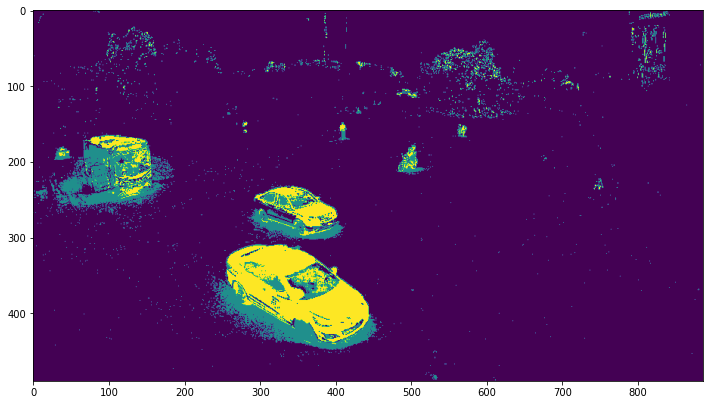

In [107]:
def train_bg_subtractor(inst, cap, num=500):
    '''
        BG substractor need process some amount of frames to start giving result
    '''
    print ('Training BG Subtractor...')
    i = 0
    for frame in cap:
        inst.apply(frame, None, 0.001)
        i += 1
        if i >= num:
            return cap

VIDEO_SOURCE = "nuevo5.mp4"

bg_subtractor = cv2.createBackgroundSubtractorMOG2(
        history=560, detectShadows=True)

# Set up image source
cap = skvideo.io.vreader(VIDEO_SOURCE)

# skipping 500 frames to train bg subtractor
train_bg_subtractor(bg_subtractor, cap, num=560)

frame = next(cap)
fg_mask = bg_subtractor.apply(frame, None, 0.001)

plt.figure(figsize=(12,12))
plt.imshow(fg_mask)
plt.show()

Como puede ver, hay algo de ruido en la máscara de primer plano que intentaremos eliminar con alguna técnica de filtrado estándar.

# Filtros

En este caso utilizaremos los siguietnes filtros: [Threshold](http://docs.opencv.org/3.1.0/d7/d4d/tutorial_py_thresholding.html), [Erode, Dilate, Opening, Closing](http://docs.opencv.org/3.1.0/d9/d61/tutorial_py_morphological_ops.html). 

Así que ahora los usaremos para eliminar algo de ruido en la máscara de primer plano.
Primero, usaremos Cerrar para eliminar espacios en áreas, luego Apertura para eliminar puntos de 1 a 2 px, y después de esa dilatación para hacer que el objeto sea más audaz.



Training BG Subtractor...


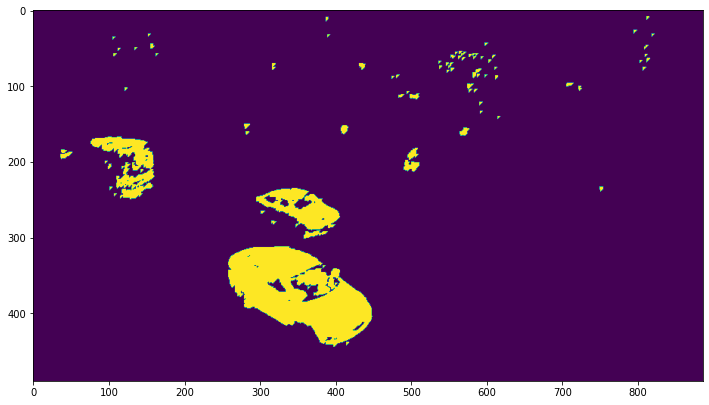

In [104]:

def filter_mask(img):
    '''
        This filters are hand-picked just based on visual tests
    '''

    kernel = cv2.getStructuringElement(cv2.MORPH_ELLIPSE, (2, 2))

    # Fill any small holes
    closing = cv2.morphologyEx(img, cv2.MORPH_CLOSE, kernel)
    # Remove noise
    opening = cv2.morphologyEx(closing, cv2.MORPH_OPEN, kernel)

    # Dilate to merge adjacent blobs
    dilation = cv2.dilate(opening, kernel, iterations=2)

    return dilation

bg_subtractor = cv2.createBackgroundSubtractorMOG2(
        history=560, detectShadows=True)

# Set up image source
cap = skvideo.io.vreader(VIDEO_SOURCE)

# skipping 500 frames to train bg subtractor
train_bg_subtractor(bg_subtractor, cap, num=560)

frame = next(cap)
fg_mask = bg_subtractor.apply(frame, None, 0.001)
fg_mask[fg_mask < 240] = 0
fg_mask = filter_mask(fg_mask)

plt.figure(figsize=(12,12))
plt.imshow(fg_mask)
plt.show()

# Detección de objetos por contorno

Para ello usaremos el método estándar cv2.findContours con *parámetros*:
```
cv2.CV_RETR_EXTERNAL — get only outer contours.
cv2.CV_CHAIN_APPROX_TC89_L1 - use Teh-Chin chain approximation algorithm (faster)
```



In [35]:
def get_centroid(x, y, w, h):
    x1 = int(w / 2)
    y1 = int(h / 2)

    cx = x + x1
    cy = y + y1

    return (cx, cy)


class ContourDetection:
    '''
        Detecting moving objects.

        Purpose of this processor is to subtrac background, get moving objects
        and detect them with a cv2.findContours method, and then filter off-by
        width and height. 

        bg_subtractor - background subtractor isinstance.
        min_contour_width - min bounding rectangle width.
        min_contour_height - min bounding rectangle height.
        save_image - if True will save detected objects mask to file.
        image_dir - where to save images(must exist).        
    '''

    def __init__(self, bg_subtractor, min_contour_width=35, min_contour_height=35, save_image=False, image_dir='images'):
        super(ContourDetection, self).__init__()

        self.bg_subtractor = bg_subtractor
        self.min_contour_width = min_contour_width
        self.min_contour_height = min_contour_height
        self.save_image = save_image
        self.image_dir = image_dir

    def filter_mask(self, img, a=None):
        '''
            This filters are hand-picked just based on visual tests
        '''

        kernel = cv2.getStructuringElement(cv2.MORPH_ELLIPSE, (2, 2))

        # Fill any small holes
        closing = cv2.morphologyEx(img, cv2.MORPH_CLOSE, kernel)
        # Remove noise
        opening = cv2.morphologyEx(closing, cv2.MORPH_OPEN, kernel)

        # Dilate to merge adjacent blobs
        dilation = cv2.dilate(opening, kernel, iterations=2)

        return dilation

    def detect_vehicles(self, fg_mask):

        matches = []

        # finding external contours
        contours, hierarchy = cv2.findContours(
            fg_mask, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_TC89_L1)

        for (i, contour) in enumerate(contours):
            (x, y, w, h) = cv2.boundingRect(contour)
            # On the exit, we add some filtering by height, width and add centroid.
            contour_valid = (w >= self.min_contour_width) and (
                h >= self.min_contour_height)

            if not contour_valid:
                continue

            centroid = get_centroid(x, y, w, h)

            matches.append(((x, y, w, h), centroid))

        return matches

    def __call__(self, frame):
        frame = frame.copy()

        fg_mask = self.bg_subtractor.apply(frame, None, 0.001)
        # just thresholding values
        fg_mask[fg_mask < 240] = 0
        fg_mask = self.filter_mask(fg_mask, 0)

        return self.detect_vehicles(fg_mask)

cd = ContourDetection(bg_subtractor)

bg_subtractor = cv2.createBackgroundSubtractorMOG2(
        history=500, detectShadows=True)

# Set up image source
cap = skvideo.io.vreader(VIDEO_SOURCE)

# skipping 500 frames to train bg subtractor
train_bg_subtractor(bg_subtractor, cap, num=500)

frame = next(cap)
objects = cd(frame)

print('Getting list of [((x,y,w,h), (xc,yc)), ...]')
print(objects)

Training BG Subtractor...
Getting list of [((x,y,w,h), (xc,yc)), ...]
[((344, 650, 120, 70), (404, 685)), ((1009, 598, 189, 122), (1103, 659)), ((1171, 581, 109, 139), (1225, 650)), ((194, 532, 131, 103), (259, 583)), ((395, 406, 61, 51), (425, 431)), ((228, 393, 142, 104), (299, 445)), ((494, 387, 68, 59), (528, 416)), ((856, 364, 55, 47), (883, 387)), ((460, 356, 49, 35), (484, 373)), ((752, 317, 79, 64), (791, 349)), ((508, 283, 54, 41), (535, 303)), ((594, 239, 52, 50), (620, 264))]


# Creando el pipeline

Se crea el un simple pipline para el procesiamiento


In [108]:

class PipelineRunner(object):

    def __init__(self, pipeline=None, log_level=logging.INFO):
        self.pipeline = pipeline or []
        self.context = {}
        self.log = logging.getLogger(self.__class__.__name__)
        self.log.setLevel(log_level)
        self.log_level = log_level
        self.set_log_level()

    def set_context(self, data):
        self.context = data

    def add(self, processor):
        if not isinstance(processor, PipelineProcessor):
            raise Exception(
                'Processor should be an isinstance of PipelineProcessor.')
        processor.log.setLevel(self.log_level)
        self.pipeline.append(processor)

    def remove(self, name):
        for i, p in enumerate(self.pipeline):
            if p.__class__.__name__ == name:
                del self.pipeline[i]
                return True
        return False

    def set_log_level(self):
        for p in self.pipeline:
            p.log.setLevel(self.log_level)

    def run(self):
        for p in self.pipeline:
            self.context = p(self.context)

        self.log.debug("Frame #%d processed.", self.context['frame_number'])

        return self.context


class PipelineProcessor(object):
    '''
        Base class for processors.
    '''

    def __init__(self):
        self.log = logging.getLogger(self.__class__.__name__)

In [37]:
def save_frame(frame, file_name, flip=True):
    # flip BGR to RGB
    if flip:
        cv2.imwrite(file_name, np.flip(frame, 2))
    else:
        cv2.imwrite(file_name, frame)

class ContourDetection(PipelineProcessor):
    '''
        Detecting moving objects.

        Purpose of this processor is to subtrac background, get moving objects
        and detect them with a cv2.findContours method, and then filter off-by
        width and height. 

        bg_subtractor - background subtractor isinstance.
        min_contour_width - min bounding rectangle width.
        min_contour_height - min bounding rectangle height.
        save_image - if True will save detected objects mask to file.
        image_dir - where to save images(must exist).        
    '''

    def __init__(self, bg_subtractor, min_contour_width=35, min_contour_height=35, save_image=False, image_dir='images'):
        super(ContourDetection, self).__init__()

        self.bg_subtractor = bg_subtractor
        self.min_contour_width = min_contour_width
        self.min_contour_height = min_contour_height
        self.save_image = save_image
        self.image_dir = image_dir

    def filter_mask(self, img, a=None):
        '''
            This filters are hand-picked just based on visual tests
        '''

        kernel = cv2.getStructuringElement(cv2.MORPH_ELLIPSE, (2, 2))

        # Fill any small holes
        closing = cv2.morphologyEx(img, cv2.MORPH_CLOSE, kernel)
        # Remove noise
        opening = cv2.morphologyEx(closing, cv2.MORPH_OPEN, kernel)

        # Dilate to merge adjacent blobs
        dilation = cv2.dilate(opening, kernel, iterations=2)

        return dilation

    def detect_vehicles(self, fg_mask, context):

        matches = []

        # finding external contours
        contours, hierarchy = cv2.findContours(
            fg_mask, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_TC89_L1)

        for (i, contour) in enumerate(contours):
            (x, y, w, h) = cv2.boundingRect(contour)
            contour_valid = (w >= self.min_contour_width) and (
                h >= self.min_contour_height)

            if not contour_valid:
                continue

            centroid = get_centroid(x, y, w, h)

            matches.append(((x, y, w, h), centroid))

        return matches

    def __call__(self, context):
        frame = context['frame'].copy()
        frame_number = context['frame_number']

        fg_mask = self.bg_subtractor.apply(frame, None, 0.001)
        # just thresholding values
        fg_mask[fg_mask < 240] = 0
        fg_mask = self.filter_mask(fg_mask, frame_number)

        if self.save_image:
            save_frame(fg_mask, self.image_dir +
                             "/mask_%04d.png" % frame_number, flip=False)

        context['objects'] = self.detect_vehicles(fg_mask, context)
        context['fg_mask'] = fg_mask

        return context


Ahora creemos un procesador que vinculará los objetos detectados en diferentes marcos y creará rutas, y también contará los vehículos que llegaron a la zona de salida.

In [38]:
def distance(x, y, type='euclidian', x_weight=1.0, y_weight=1.0):
    if type == 'euclidian':
        return math.sqrt(float((x[0] - y[0])**2) / x_weight + float((x[1] - y[1])**2) / y_weight)


class VehicleCounter(PipelineProcessor):
    '''
        Counting vehicles that entered in exit zone.

        Purpose of this class based on detected object and local cache create
        objects pathes and count that entered in exit zone defined by exit masks.

        exit_masks - list of the exit masks.
        path_size - max number of points in a path.
        max_dst - max distance between two points.
    '''

    def __init__(self, exit_masks=[], path_size=10, max_dst=30, x_weight=1.0, y_weight=1.0):
        super(VehicleCounter, self).__init__()

        self.exit_masks = exit_masks

        self.vehicle_count = 0
        self.path_size = path_size
        self.pathes = []
        self.max_dst = max_dst
        self.x_weight = x_weight
        self.y_weight = y_weight

    def check_exit(self, point):
        for exit_mask in self.exit_masks:
            try:
                if exit_mask[point[1]][point[0]] == 255:
                    return True
            except:
                return True
        return False

    def __call__(self, context):
        objects = context['objects']
        context['exit_masks'] = self.exit_masks
        context['pathes'] = self.pathes
        context['vehicle_count'] = self.vehicle_count
        if not objects:
            return context

        points = np.array(objects)[:, 0:2]
        points = points.tolist()

        # add new points if pathes is empty
        if not self.pathes:
            for match in points:
                self.pathes.append([match])

        else:
            # link new points with old pathes based on minimum distance between
            # points
            new_pathes = []

            for path in self.pathes:
                _min = 999999
                _match = None
                for p in points:
                    if len(path) == 1:
                        # distance from last point to current
                        d = distance(p[0], path[-1][0])
                    else:
                        # based on 2 prev points predict next point and calculate
                        # distance from predicted next point to current
                        xn = 2 * path[-1][0][0] - path[-2][0][0]
                        yn = 2 * path[-1][0][1] - path[-2][0][1]
                        d = distance(
                            p[0], (xn, yn),
                            x_weight=self.x_weight,
                            y_weight=self.y_weight
                        )

                    if d < _min:
                        _min = d
                        _match = p

                if _match and _min <= self.max_dst:
                    points.remove(_match)
                    path.append(_match)
                    new_pathes.append(path)

                # do not drop path if current frame has no matches
                if _match is None:
                    new_pathes.append(path)

            self.pathes = new_pathes

            # add new pathes
            if len(points):
                for p in points:
                    # do not add points that already should be counted
                    if self.check_exit(p[1]):
                        continue
                    self.pathes.append([p])

        # save only last N points in path
        for i, _ in enumerate(self.pathes):
            self.pathes[i] = self.pathes[i][self.path_size * -1:]

        # count vehicles and drop counted pathes:
        new_pathes = []
        for i, path in enumerate(self.pathes):
            d = path[-2:]

            if (
                # need at list two points to count
                len(d) >= 2 and
                # prev point not in exit zone
                not self.check_exit(d[0][1]) and
                # current point in exit zone
                self.check_exit(d[1][1]) and
                # path len is bigger then min
                self.path_size <= len(path)
            ):
                self.vehicle_count += 1
            else:
                # prevent linking with path that already in exit zone
                add = True
                for p in path:
                    if self.check_exit(p[1]):
                        add = False
                        break
                if add:
                    new_pathes.append(path)

        self.pathes = new_pathes

        context['pathes'] = self.pathes
        context['objects'] = objects
        context['vehicle_count'] = self.vehicle_count

        self.log.debug('#VEHICLES FOUND: %s' % self.vehicle_count)

        return context



En este punto la idea es crear una máscara, que es la zona dónde se contarán los vehículos, para eliminar un poco de ruido y saber el número de veículo que circulo en cada calle.

Para ello definiermos la masácara como uan lista de puntos

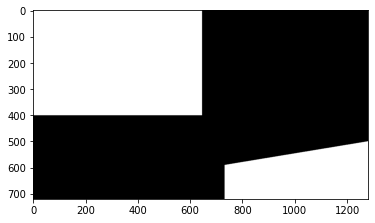

In [39]:
EXIT_PTS = np.array([
    [[732, 720], [732, 590], [1280, 500], [1280, 720]],
    [[0, 400], [645, 400], [645, 0], [0, 0]]
])
SHAPE = (720,1280)
base = np.zeros(SHAPE + (3,), dtype='uint8')
exit_mask = cv2.fillPoly(base, EXIT_PTS, (255, 255, 255))[:, :, 0]

plt.imshow(base)
plt.show()

En el primer fotograma. simplemente agregamos todos los puntos como nuevos caminos.

A continuación, si len (ruta) == 1, para cada ruta en la caché estamos tratando de encontrar el punto (centroide) de los objetos recién detectados que tendrán la distancia euclidiana más pequeña hasta el último punto de la ruta.

Si len (ruta)> 1, entonces con los dos últimos puntos en la ruta estamos prediciendo un nuevo punto en la misma línea y encontrando la distancia mínima entre este y el punto actual.

El punto con una distancia mínima agregada al final de la ruta actual y eliminada de la lista.

Si quedan algunos puntos después de esto, los agregamos como nuevos caminos.


Ahora intentaremos contar los vehículos que ingresan en la zona de salida. Para hacer esto, simplemente tomamos 2 últimos puntos en la ruta y comprobamos que el último de ellos en la zona de salida, y el anterior no, y también verificamos que len (ruta) debe ser mayor que el límite.
La parte después de lo demás es evitar la vinculación de nuevos puntos a los puntos en la zona de salida.

Y los dos últimos procesadores son un escritor CSV para crear un archivo CSV de informes y visualización para depurar y agradables imágenes / videos.


In [112]:
class CsvWriter(PipelineProcessor):

    def __init__(self, path, name, start_time=0, fps=15):
        super(CsvWriter, self).__init__()

        self.fp = open(os.path.join(path, name), 'w')
        self.writer = csv.DictWriter(self.fp, fieldnames=['time', 'vehicles'])
        self.writer.writeheader()
        self.start_time = start_time
        self.fps = fps
        self.path = path
        self.name = name
        self.prev = None

    def __call__(self, context):
        frame_number = context['frame_number']
        count = _count = context['vehicle_count']

        if self.prev:
            _count = count - self.prev

        time = ((self.start_time + int(frame_number / self.fps)) * 100 
                + int(100.0 / self.fps) * (frame_number % self.fps))
        self.writer.writerow({'time': time, 'vehicles': _count})
        self.prev = count

        return context

BOUNDING_BOX_COLOUR = (255, 192, 0)
CENTROID_COLOUR = (255, 192, 0)
CAR_COLOURS = [(255, 192, 0)]
EXIT_COLOR = (66, 183, 42)

class Visualizer(PipelineProcessor):

    def __init__(self, save_image=True, image_dir='images'):
        super(Visualizer, self).__init__()

        self.save_image = save_image
        self.image_dir = image_dir

    def check_exit(self, point, exit_masks=[]):
        for exit_mask in exit_masks:
            if exit_mask[point[1]][point[0]] == 255:
                return True
        return False

    def draw_pathes(self, img, pathes):
        if not img.any():
            return

        for i, path in enumerate(pathes):
            path = np.array(path)[:, 1].tolist()
            for point in path:
                cv2.circle(img, point, 2, CAR_COLOURS[0], -1)
                cv2.polylines(img, [np.int32(path)], False, CAR_COLOURS[0], 1)

        return img

    def draw_boxes(self, img, pathes, exit_masks=[]):
        for (i, match) in enumerate(pathes):

            contour, centroid = match[-1][:2]
            if self.check_exit(centroid, exit_masks):
                continue

            x, y, w, h = contour

            cv2.rectangle(img, (x, y), (x + w - 1, y + h - 1),
                          BOUNDING_BOX_COLOUR, 1)
            cv2.circle(img, centroid, 2, CENTROID_COLOUR, -1)

        return img

    def draw_ui(self, img, vehicle_count, exit_masks=[]):

        # this just add green mask with opacity to the image
        for exit_mask in exit_masks:
            _img = np.zeros(img.shape, img.dtype)
            _img[:, :] = EXIT_COLOR
            mask = cv2.bitwise_and(_img, _img, mask=exit_mask)
            cv2.addWeighted(mask, 1, img, 1, 0, img)

        # drawing top block with counts
        cv2.rectangle(img, (0, 0), (img.shape[1], 50), (0, 0, 0), cv2.FILLED)
        cv2.putText(img, ("Conteo: {total} ".format(total=vehicle_count)), (30, 30),
                    cv2.FONT_HERSHEY_SIMPLEX, 0.7, (255, 255, 255), 1)
        return img

    def __call__(self, context):
        frame = context['frame'].copy()
        frame = np.ascontiguousarray(np.flip(frame, 2))
        frame_number = context['frame_number']
        pathes = context['pathes']
        exit_masks = context['exit_masks']
        vehicle_count = context['vehicle_count']

        frame = self.draw_ui(frame, vehicle_count, exit_masks)
        frame = self.draw_pathes(frame, pathes)
        frame = self.draw_boxes(frame, pathes, exit_masks)
        if self.save_image:
            save_frame(frame, self.image_dir +
                            "/processed_%04d.png" % frame_number)

        context['frame'] = frame
        return context

Los dato deberán estar guardados por itnerbalo  de tiempo  porque los precisamos para su posteriro análisis 

```
time = ((self.start_time + int(frame_number / self.fps)) * 100 
                + int(100.0 / self.fps) * (frame_number % self.fps))
```

```
so with start time=1 000 000 000 and fps=10 i will get results like this
frame 1 = 1 000 000 000 010
frame 1 = 1 000 000 000 020
…
```



Then after you get full csv report you can aggregate this data as you want.

## Evaluación del modelo

Creamos el modelo y lo probamos con distintos videos.

In [ ]:
# build runner
def main():
    log = logging.getLogger("main")

    # creating exit mask from points, where we will be counting our vehicles
    base = np.zeros(SHAPE + (3,), dtype='uint8')
    exit_mask = cv2.fillPoly(base, EXIT_PTS, (255, 255, 255))[:, :, 0]

    # there is also bgslibrary, that seems to give better BG substruction, but
    # not tested it yet
    bg_subtractor = cv2.createBackgroundSubtractorMOG2(
        history=500, detectShadows=True)

    # processing pipline for programming conviniance
    pipeline = PipelineRunner(pipeline=[
        ContourDetection(bg_subtractor=bg_subtractor,
                         save_image=True, image_dir=IMAGE_DIR),
        # we use y_weight == 2.0 because traffic are moving vertically on video
        # use x_weight == 2.0 for horizontal.
        VehicleCounter(exit_masks=[exit_mask], y_weight=2.0),
        Visualizer(image_dir=IMAGE_DIR,save_image=False),
        CsvWriter(path='./', name='report.csv')
    ], log_level=logging.INFO)

    # Set up image source
    cap = skvideo.io.vreader(VIDEO_SOURCE)

    # skipping 500 frames to train bg subtractor
    train_bg_subtractor(bg_subtractor, cap, num=500)

    fourcc = cv2.VideoWriter_fourcc(*"MP4V")
    writer = cv2.VideoWriter(VIDEO_OUT, fourcc, 25, (SHAPE[1], SHAPE[0]), True)

    frame_number = -1
    for frame in cap:
        if not frame.any():
            log.error("Frame capture failed, stopping...")
            break

        frame_number += 1
        log.info("Frame #%s" % frame_number)

        pipeline.set_context({
            'frame': frame,
            'frame_number': frame_number,
        })
        ctx = pipeline.run()
        writer.write(ctx['frame'])

        if frame_number > PARSE_FRAMES:
            break
    writer.release()

In [114]:
# Parameters
# ============================================================================
IMAGE_DIR = "./out"
VIDEO_SOURCE = "nuevo5.mp4"
VIDEO_OUT = "road_parsed.mp4"
PARSE_FRAMES = 325*15
SHAPE = (490, 886)  # HxW
EXIT_PTS = np.array([
    [
    #  [600, 200], [700, 220], [640, 280], [500, 220],
     [640, 290], [886, 360], [886, 490], [540, 490]
    ]
])
# ============================================================================

log = init_logging()
main()

Training BG Subtractor...
2021-01-17 23:43:51.721 INFO     [main] Frame #0
2021-01-17 23:43:51.760 INFO     [main] Frame #1
2021-01-17 23:43:51.801 INFO     [main] Frame #2
2021-01-17 23:43:51.839 INFO     [main] Frame #3
2021-01-17 23:43:51.874 INFO     [main] Frame #4
2021-01-17 23:43:51.909 INFO     [main] Frame #5


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:47: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:53: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray


2021-01-17 23:43:51.946 INFO     [main] Frame #6
2021-01-17 23:43:51.983 INFO     [main] Frame #7
2021-01-17 23:43:52.023 INFO     [main] Frame #8
2021-01-17 23:43:52.056 INFO     [main] Frame #9
2021-01-17 23:43:52.091 INFO     [main] Frame #10
2021-01-17 23:43:52.130 INFO     [main] Frame #11
2021-01-17 23:43:52.175 INFO     [main] Frame #12
2021-01-17 23:43:52.216 INFO     [main] Frame #13
2021-01-17 23:43:52.247 INFO     [main] Frame #14
2021-01-17 23:43:52.285 INFO     [main] Frame #15
2021-01-17 23:43:52.325 INFO     [main] Frame #16
2021-01-17 23:43:52.361 INFO     [main] Frame #17
2021-01-17 23:43:52.400 INFO     [main] Frame #18
2021-01-17 23:43:52.436 INFO     [main] Frame #19
2021-01-17 23:43:52.473 INFO     [main] Frame #20
2021-01-17 23:43:52.510 INFO     [main] Frame #21
2021-01-17 23:43:52.552 INFO     [main] Frame #22
2021-01-17 23:43:52.592 INFO     [main] Frame #23
2021-01-17 23:43:52.631 INFO     [main] Frame #24
2021-01-17 23:43:52.673 INFO     [main] Frame #25
2021

Resultado: https://youtu.be/ww3wqHSU50Y